In [2]:
import pandas as pd
import json
import ast
from pathlib import Path
import os

import preprocess_utils as p_u

### 1. Processing data for multi-label classification (Dataset: small, extraction-type: BOTH)

#### Read data from individual csv files

In [3]:
all_dfs_list = p_u.get_data_small()
all_dfs_lengths = [d_frame.shape[0] for d_frame in all_dfs_list]
print(all_dfs_lengths)

[10000, 5917, 234, 182, 6253, 330, 1705]


In [4]:
all_dfs_list[0].head(2)

,fid,mtype,exprstr,mention,tokens,type_tokens,tags
0,6327106106a69a3f488d6e3e_f_8_2_0,FUNC,f,any function,['f'],"['func_name', '__ANON_1']","['elementary-set-theory', 'intuition', 'infini..."
1,6327106106a69a3f488d6e96_f_3_22_0,FUNC,"j: \mathbb{N} \rightarrow [0, 1]",any injection f_3_22_0,"['j', ':', '\\mathbb{N}', '\\rightarrow', '[',...","['func_def', 'func_name', '__ANON_1', 'COLON',...",['elementary-set-theory']


#### Merge all datasets to create a multiclass training dataset

In [5]:
intended_num_samples_per_class = -1 # set to -1 to get all available -> set arbitrary number to get more balanced dataset
all_samples_df = p_u.merge_dfs_list(all_dfs_list, intended_num_samples_per_class)
all_samples_df.head()
print("merged df size: ", all_samples_df.shape[0])


merged df size:  24621


#### Labels distribution: Extract class labels and assign values

In [6]:
labels_frequencies_dict, labels_ids_dict = p_u.get_labels_frequencies(all_samples_df)
all_samples_df.head(2)

,fid,mtype,exprstr,mention,tokens,type_tokens,tags,labels
0,6327106106a69a3f488d6e3e_f_8_2_0,FUNC,f,any function,['f'],"['func_name', '__ANON_1']","['elementary-set-theory', 'intuition', 'infini...","[elementary-set-theory, intuition, infinity, faq]"
1,6327106106a69a3f488d6e96_f_3_22_0,FUNC,"j: \mathbb{N} \rightarrow [0, 1]",any injection f_3_22_0,"['j', ':', '\\mathbb{N}', '\\rightarrow', '[',...","['func_def', 'func_name', '__ANON_1', 'COLON',...",['elementary-set-theory'],[elementary-set-theory]


In [7]:
print(labels_ids_dict)

{'elementary-set-theory': 0, 'intuition': 1, 'infinity': 2, 'faq': 3, 'irrational-numbers': 4, 'functions': 5, 'function-and-relation-composition': 6, 'terminology': 7, 'discrete-mathematics': 8, 'equivalence-relations': 9, 'real-analysis': 10, 'induction': 11, 'natural-numbers': 12, 'measure-theory': 13, 'algebra-precalculus': 14, 'notation': 15, 'relations': 16, 'elementary-number-theory': 17, 'physics': 18, 'philosophy': 19, 'logic': 20, 'cardinals': 21, 'transfinite-recursion': 22, 'analysis': 23, 'general-topology': 24, 'order-theory': 25, 'lattice-orders': 26, 'limsup-and-liminf': 27, 'computer-science': 28, 'definition': 29, 'combinatorics': 30, 'soft-question': 31, 'calculus': 32, 'axiom-of-choice': 33, 'puzzle': 34, 'category-theory': 35, 'limits-colimits': 36, 'axioms': 37, 'model-theory': 38, 'set-partition': 39, 'proof-verification': 40, 'proof-writing': 41, 'lambda-calculus': 42, 'functional-analysis': 43, 'limits': 44, 'continuity': 45, 'decimal-expansion': 46, 'ordinals'

In [8]:
# get dictionary of 
NUM_TOP_VALUES = 40
print("Total number of classes: ", len(labels_frequencies_dict))
print("--------------------------------------------")
# if no
selected_labels_freq = p_u.get_top_frequencies(labels_frequencies_dict, NUM_TOP_VALUES)
for label, freq in selected_labels_freq[:40]:
    print(label + ": " + str(freq))

Total number of classes:  708
--------------------------------------------
elementary-set-theory: 10215
elementary-number-theory: 6604
algebra-precalculus: 6454
functions: 3713
trigonometry: 1933
number-theory: 1368
calculus: 1080
real-analysis: 1019
discrete-mathematics: 880
combinatorics: 800
proof-verification: 758
prime-numbers: 721
cardinals: 698
proof-writing: 594
contest-math: 562
divisibility: 554
solution-verification: 522
modular-arithmetic: 522
inequality: 486
notation: 481
geometry: 425
general-topology: 396
sequences-and-series: 388
polynomials: 378
logic: 373
euclidean-geometry: 364
abstract-algebra: 335
arithmetic: 324
relations: 311
definition: 288
analytic-geometry: 276
decimal-expansion: 275
recreational-mathematics: 261
proof-explanation: 260
functional-equations: 256
elementary-functions: 251
limits: 234
induction: 230
complex-numbers: 214
terminology: 208


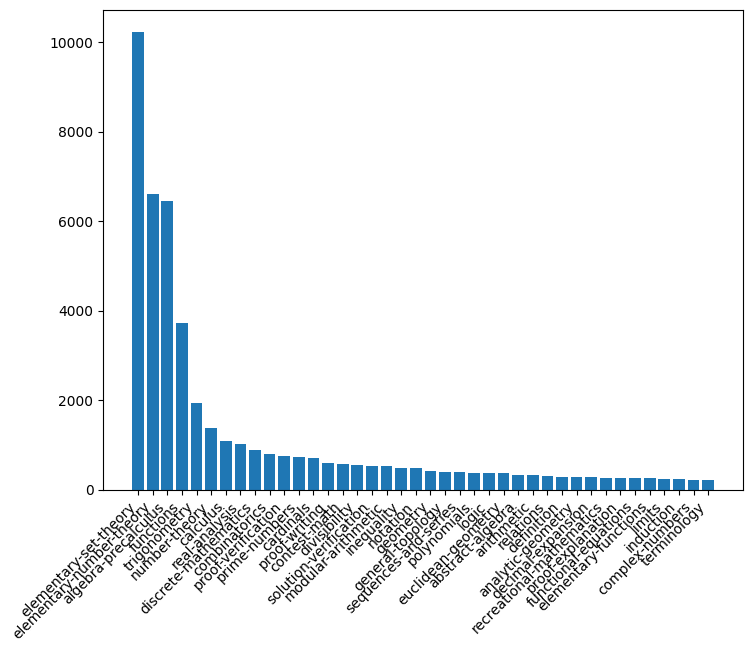

In [9]:
p_u.plot_label_frequencies(selected_labels_freq)

#### Top (num) selected labels by frequency are kept, other classes are discarded

In [10]:

all_samples_df = all_samples_df.drop(["fid", "exprstr", "mention", "tags"], axis=1)
selected_labels = [label for (label, freq) in selected_labels_freq]
all_samples_df, ids_to_pos_index_dict = p_u.labels_to_multi_hot(all_samples_df, selected_labels,labels_ids_dict)

In [11]:
print(all_samples_df.shape[0])

24621


In [12]:
all_samples_df.head(2)

,mtype,tokens,type_tokens,labels,labels_str
0,FUNC,['f'],"['func_name', '__ANON_1']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[elementary-set-theory]
1,FUNC,"['j', ':', '\\mathbb{N}', '\\rightarrow', '[',...","['func_def', 'func_name', '__ANON_1', 'COLON',...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[elementary-set-theory]


In [13]:
for label in selected_labels:
    one_hot_index = ids_to_pos_index_dict[labels_ids_dict[label]]
    print("label: " + str(label) + ", one hot index: " + str(one_hot_index))

label: elementary-set-theory, one hot index: 0
label: elementary-number-theory, one hot index: 1
label: algebra-precalculus, one hot index: 2
label: functions, one hot index: 3
label: trigonometry, one hot index: 4
label: number-theory, one hot index: 5
label: calculus, one hot index: 6
label: real-analysis, one hot index: 7
label: discrete-mathematics, one hot index: 8
label: combinatorics, one hot index: 9
label: proof-verification, one hot index: 10
label: prime-numbers, one hot index: 11
label: cardinals, one hot index: 12
label: proof-writing, one hot index: 13
label: contest-math, one hot index: 14
label: divisibility, one hot index: 15
label: solution-verification, one hot index: 16
label: modular-arithmetic, one hot index: 17
label: inequality, one hot index: 18
label: notation, one hot index: 19
label: geometry, one hot index: 20
label: general-topology, one hot index: 21
label: sequences-and-series, one hot index: 22
label: polynomials, one hot index: 23
label: logic, one hot

In [14]:
all_samples_df = p_u.types_to_one_hot(all_samples_df)

In [15]:
output_path = Path("..") / "data" / "multi_class_unbalanced_data_TOKENIZED_V1.csv"
all_samples_df.to_csv(output_path, index=False)

#### ALTERNATIVELY: Remove single - token formulas from dataset

In [16]:
clean_data_df = all_samples_df.loc[all_samples_df["tokens"].str.len() > 5]
clean_data_df.head()

,mtype,tokens,type_tokens,labels,labels_str,mtype_one_hot
1,FUNC,"['j', ':', '\\mathbb{N}', '\\rightarrow', '[',...","['func_def', 'func_name', '__ANON_1', 'COLON',...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[elementary-set-theory],"[0, 0, 1]"
3,SET,\mathbb{Q},"['set_constant', 'SET_BASIC']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[elementary-set-theory],"[1, 0, 0]"
5,FUNC,"['f', '(', 'x', ')', '=', 'x', '+', '1', '0']","['func_expr', 'func_name_arg', 'func_name', '_...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[functions, elementary-set-theory]","[0, 0, 1]"
6,FUNC,"['f', '(', 'x', ')', '=', '9', 'x']","['func_expr', 'func_name_arg', 'func_name', '_...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[functions, elementary-set-theory]","[0, 0, 1]"
7,FUNC,"['f', '(', 'x', ')', '=', 'x', '^', '2', '+', ...","['func_expr', 'func_name_arg', 'func_name', '_...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[functions, elementary-set-theory]","[0, 0, 1]"


In [17]:
output_path = Path("..") / "data" / "multi_class_unbalanced_data_TOKENIZED_V1_compact.csv"
clean_data_df.to_csv(output_path, index=False)
print(clean_data_df.shape[0])

13772


### 2. Processing data for multi-label classification (Dataset: large, extraction-type: FORMULA)

#### Read data from individual csv files

In [18]:
all_dfs_list = p_u.get_data_large()
all_dfs_lengths = [d_frame.shape[0] for d_frame in all_dfs_list]
print(all_dfs_lengths)

[20000, 20000, 11556, 7146, 20000, 11830, 15990]


In [19]:
all_dfs_list[0].head(2)

,fid,mtype,exprstr,mention,tags,tokens,type_tokens
0,6327106106a69a3f488d6ea5_f_1_0_0,SET,\mathbb R^N,the sequence space,"['real-analysis', 'elementary-set-theory', 'ca...","['\\mathbb', 'R', '^', 'N']","['set_expr', 'SET_FAT', '__ANON_0', 'CARET', '..."
1,6327106106a69a3f488d6f48_f_1_1_0,FUNC,f : S \to S,NaN,"['functions', 'elementary-set-theory', 'functi...","['f', ':', 'S', '\\to', 'S']","['func_def', 'func_name', '__ANON_1', 'COLON',..."


#### Merge all datasets to create a multiclass training dataset

In [20]:
intended_num_samples_per_class = -1 # set to -1 to get all available -> set arbitrary number to get more balanced dataset
all_samples_df = p_u.merge_dfs_list(all_dfs_list, intended_num_samples_per_class)
all_samples_df.head()
print("merged df size: ", all_samples_df.shape[0])

merged df size:  106522


#### Labels distribution: Extract class labels and assign values

In [21]:
labels_frequencies_dict, labels_ids_dict = p_u.get_labels_frequencies(all_samples_df)
all_samples_df.head(2)

,fid,mtype,exprstr,mention,tags,tokens,type_tokens,labels
0,6327106106a69a3f488d6ea5_f_1_0_0,SET,\mathbb R^N,the sequence space,"['real-analysis', 'elementary-set-theory', 'ca...","['\\mathbb', 'R', '^', 'N']","['set_expr', 'SET_FAT', '__ANON_0', 'CARET', '...","[real-analysis, elementary-set-theory, cardinals]"
1,6327106106a69a3f488d6f48_f_1_1_0,FUNC,f : S \to S,NaN,"['functions', 'elementary-set-theory', 'functi...","['f', ':', 'S', '\\to', 'S']","['func_def', 'func_name', '__ANON_1', 'COLON',...","[functions, elementary-set-theory, function-an..."


In [22]:
print(labels_ids_dict)

{'real-analysis': 0, 'elementary-set-theory': 1, 'cardinals': 2, 'functions': 3, 'function-and-relation-composition': 4, 'field-theory': 5, 'measure-theory': 6, 'algebra-precalculus': 7, 'elementary-number-theory': 8, 'discrete-mathematics': 9, 'physics': 10, 'infinity': 11, 'philosophy': 12, 'intuition': 13, 'axiom-of-choice': 14, 'relations': 15, 'equivalence-relations': 16, 'arithmetic': 17, 'natural-numbers': 18, 'fake-proofs': 19, 'fixed-point-theorems': 20, 'combinatorics': 21, 'definition': 22, 'linear-algebra': 23, 'calculus': 24, 'analysis': 25, 'puzzle': 26, 'axioms': 27, 'inclusion-exclusion': 28, 'graph-theory': 29, 'proof-verification': 30, 'functional-equations': 31, 'general-topology': 32, 'set-partition': 33, 'number-systems': 34, 'proof-writing': 35, 'alternative-proof': 36, 'abstract-algebra': 37, 'computer-science': 38, 'lambda-calculus': 39, 'notation': 40, 'continuity': 41, 'associativity': 42, 'geometry': 43, 'complex-numbers': 44, 'modular-arithmetic': 45, 'induc

In [23]:
# get dictionary of 
NUM_TOP_VALUES = 40
print("Total number of classes: ", len(labels_frequencies_dict))
print("--------------------------------------------")
# if no
selected_labels_freq = p_u.get_top_frequencies(labels_frequencies_dict, NUM_TOP_VALUES)
for label, freq in selected_labels_freq[:40]:
    print(label + ": " + str(freq))

Total number of classes:  850
--------------------------------------------
algebra-precalculus: 24638
elementary-number-theory: 21186
elementary-set-theory: 20723
trigonometry: 18012
geometry: 15148
euclidean-geometry: 13260
analytic-geometry: 13112
elementary-functions: 7233
functions: 6227
calculus: 5791
polynomials: 3588
real-analysis: 3564
number-theory: 3497
prime-numbers: 2924
triangles: 2696
linear-algebra: 2549
circles: 2499
combinatorics: 2433
divisibility: 2265
proof-verification: 2063
contest-math: 1976
conic-sections: 1872
modular-arithmetic: 1846
discrete-mathematics: 1824
inequality: 1748
general-topology: 1728
proof-writing: 1710
abstract-algebra: 1592
complex-numbers: 1506
sequences-and-series: 1424
cardinals: 1358
closed-form: 1330
roots: 1329
integration: 1180
limits: 1172
diophantine-equations: 1058
induction: 1057
arithmetic: 995
probability: 990
notation: 970


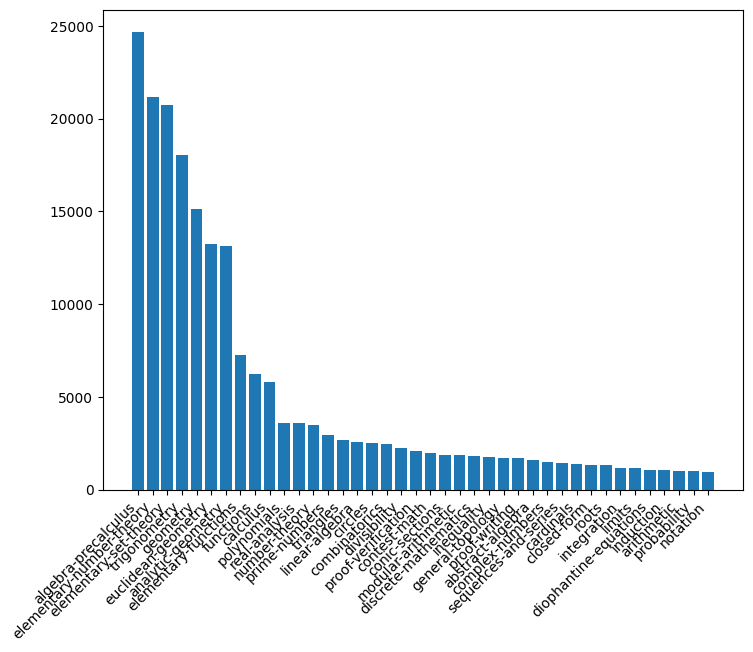

In [24]:
p_u.plot_label_frequencies(selected_labels_freq)

#### Top (num) selected labels by frequency are kept, other classes are discarded

In [25]:
all_samples_df = all_samples_df.drop(["fid", "exprstr", "mention", "tags"], axis=1)
selected_labels = [label for (label, freq) in selected_labels_freq]
all_samples_df, ids_to_pos_index_dict = p_u.labels_to_multi_hot(all_samples_df, selected_labels,labels_ids_dict)

In [26]:
print(all_samples_df.shape[0])

106522


In [27]:
all_samples_df.head(2)

,mtype,tokens,type_tokens,labels,labels_str
0,SET,"['\\mathbb', 'R', '^', 'N']","['set_expr', 'SET_FAT', '__ANON_0', 'CARET', '...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[real-analysis, elementary-set-theory, cardinals]"
1,FUNC,"['f', ':', 'S', '\\to', 'S']","['func_def', 'func_name', '__ANON_1', 'COLON',...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[functions, elementary-set-theory]"


In [28]:
for label in selected_labels:
    one_hot_index = ids_to_pos_index_dict[labels_ids_dict[label]]
    print("label: " + str(label) + ", one hot index: " + str(one_hot_index))

label: algebra-precalculus, one hot index: 0
label: elementary-number-theory, one hot index: 1
label: elementary-set-theory, one hot index: 2
label: trigonometry, one hot index: 3
label: geometry, one hot index: 4
label: euclidean-geometry, one hot index: 5
label: analytic-geometry, one hot index: 6
label: elementary-functions, one hot index: 7
label: functions, one hot index: 8
label: calculus, one hot index: 9
label: polynomials, one hot index: 10
label: real-analysis, one hot index: 11
label: number-theory, one hot index: 12
label: prime-numbers, one hot index: 13
label: triangles, one hot index: 14
label: linear-algebra, one hot index: 15
label: circles, one hot index: 16
label: combinatorics, one hot index: 17
label: divisibility, one hot index: 18
label: proof-verification, one hot index: 19
label: contest-math, one hot index: 20
label: conic-sections, one hot index: 21
label: modular-arithmetic, one hot index: 22
label: discrete-mathematics, one hot index: 23
label: inequality, 

In [29]:
all_samples_df = p_u.types_to_one_hot(all_samples_df)

In [30]:
output_path = Path("..") / "data" / "multi_class_unbalanced_data_TOKENIZED_V2.csv"
all_samples_df.to_csv(output_path, index=False)

#### ALTERNATIVELY: Remove single - token formulas from dataset

In [31]:
clean_data_df = all_samples_df.loc[all_samples_df["tokens"].str.len() > 5]
clean_data_df.head()

,mtype,tokens,type_tokens,labels,labels_str,mtype_one_hot
0,SET,"['\\mathbb', 'R', '^', 'N']","['set_expr', 'SET_FAT', '__ANON_0', 'CARET', '...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[real-analysis, elementary-set-theory, cardinals]","[1, 0, 0]"
1,FUNC,"['f', ':', 'S', '\\to', 'S']","['func_def', 'func_name', '__ANON_1', 'COLON',...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[functions, elementary-set-theory]","[0, 0, 1]"
2,FUNC,"['D', '(', 'q', ')', '=', '1', '/', '(', '1', ...","['func_expr', 'func_name_arg', 'func_name', '_...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[elementary-set-theory],"[0, 0, 1]"
3,FUNC,"['f', '(', 'x', ')', '=', '\\{', 'x', '\\}']","['func_expr', 'func_name_arg', 'func_name', '_...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[elementary-set-theory],"[0, 0, 1]"
4,FUNC,"['f', '(', 'x', ')', '=', '\\frac', '{', 'x', ...","['func_expr', 'func_name_arg', 'func_name', '_...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[functions, elementary-set-theory]","[0, 0, 1]"


In [32]:
output_path = Path("..") / "data" / "multi_class_unbalanced_data_TOKENIZED_V2_compact.csv"
clean_data_df.to_csv(output_path, index=False)
print(clean_data_df.shape[0])

57885


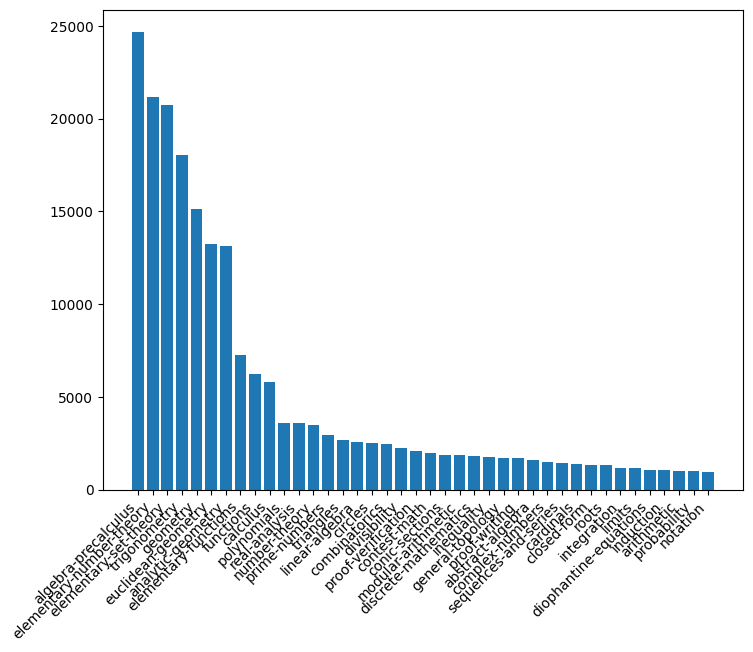

In [33]:
temp = selected_labels_freq

p_u.plot_label_frequencies(selected_labels_freq)